# Optimisation des tournées pour l’entretien des arbres de la ville de Paris

![Logo de la ville de Paris](data/image/logo.png)

L'objectif est de réaliser une analyse exploratoire à partir du jeu de données de [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/les-arbres/map/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6Imxlcy1hcmJyZXMiLCJvcHRpb25zIjp7fX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJBVkciLCJ5QXhpcyI6ImlkYmFzZSIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiMwMDMzNjYifV0sInhBeGlzIjoidHlwZWVtcGxhY2VtZW50IiwibWF4cG9pbnRzIjo1MCwic29ydCI6IiJ9XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=13,48.86844,2.30945&basemap=jawg.streets) portant sur les arbres de la ville de Paris, dans le cadre du programme “Végétalisons la ville”.

![Végétalisons Paris](data/image/Végétalisation-de-Paris.png)

Les résultats contribueront à une optimisation des tournées pour l’entretien des arbres de la ville. Car s'il y a moins de déplacements, il y a moins de trajets donc plus d’arbres maintenus.

Nous commencerons par mettre en place notre environnement de travail. Ensuite, nous procèderons à une exploration des données. Puis, un nettoyage de ces données. Par la suite, nous les analyserons. De ces analyses, nous en ferons des visualisations pour finaliser avec une synthèse.

Les étapes sont accompagnées d’explications vulgarisées pour le rendre accessible à tout public.

## Mise en place de l'environnement de travail

![Logo de Conda](data/image/conda.png)

Avant de commencer à étudier le sujet, nous allons d'abord mettre en place notre environnement afin de travailler dans des conditions favorables.

Dans cette étape, nous isolons notre travail dans un environnement virtuel avec toutes les dépendances nécessaires à son fonctionnement à l'aide de l'outil Conda d’Anaconda.

In [1]:
# Installation des dépendances
# import sys
# !conda install --yes --prefix {sys.prefix} --file requirements.txt

## Chargement des librairies

Une fois dans l’environnement virtuel, nous pouvons charger les dépendances nécessaires à la réalisation du projet.

In [2]:
import branca
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from folium.features import GeoJsonPopup, GeoJsonTooltip

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

## Chargement du jeu de données

Nous demandons à Pandas, qui est un outil d'analyse de données, de lire le contenu du fichier.

In [3]:
df = pd.read_csv('data/p2-arbres-fr.csv', sep=";")

## Exploration du jeu de données

Dans cette étape, nous allons explorer le contenu du fichier.

### Dimensionnalité

In [4]:
print(
    f"Le fichier est constitué de {df.shape[0]} lignes et de {df.shape[1]} colonnes."
)

Le fichier est constitué de 200137 lignes et de 18 colonnes.


### Information

In [5]:
print(f"Le type de données pour chaque colonne est : \n")

df.info()

Le type de données pour chaque colonne est : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  

Nous pouvons remarquer l'existence de données manquantes (NULL ou NaN), dont 100% pour la colonne "numero".
Explorons un peu plus en détail ces données manquantes. Ensuite, vérifions si les types correspondent bien aux colonnes.

### Données manquantes

In [6]:
pd.DataFrame(df.isna().mean().round(4) * 100,
             columns=['Données manquantes en %'
                      ]).sort_values(by='Données manquantes en %',
                                     ascending=False)

,Données manquantes en %
numero,100.00
complement_addresse,84.56
variete,81.62
stade_developpement,33.58
remarquable,31.53
espece,0.88
libelle_francais,0.75
genre,0.01
geo_point_2d_a,0.00
hauteur_m,0.00


Analysons brièvement les colonnes contenant des valeurs manquantes dans l'ordre décroissant.

- **"numero"** à 100% : corresponds certainement au numéro d'adresse de "lieu". La colonne "lieu" indiquant déjà l'adresse, il ne semble pas nécessaire de corriger ou conserver cette colonne.
- **"complement_adresse"** à 84,6% : les adresses ne contiennent pas forcément des compléments, cependant par rapport au lieu ou aux points géographiques nous pouvons déterminer si des compléments sont manquants.
- **"variete"** à 81,6% : afin de remplir les données manquantes, nous pouvons analyser les colonnes "libelle_francais", "genre" et "espece" qui contiennent des variétés et analyser la corrélation.
- **"stade_developpement"** à 33,6% : Corresponds à l'âge de l'arbre. Il nous est possible d'estimer les valeurs NULL en comparant "libelle_francais", "genre", "espece" ou "variete" avec "circonference_cm" et "hauteur_m".
- **"remarquable"** à 31,5% : Un arbre remarquable relève d'un patrimoine par sa rareté, ses dimensions, sa position, son âge ou encore sa force symbolique. Certaines valeurs peuvent donc être estimées par des critères concrets comme l'espèce, la hauteur, la dimension, le stade de développement ou la position, mais aussi par des critères abstraits comme le symbole. Comme il est difficile d'estimer une valeur basée sur une notion abstraite, il est possible d'améliorer la pertinence en collectant des données externes permettant de remplir ces valeurs.
- **"espece"** à 0,9%, **"libelle_francais"** à 0,7% et **"genre"** à 0,01% : Le nombre de valeurs manquantes étant très faible il sera aisé de les remplir en utilisant une méthode semblable à "variete".
- **"id"** à 0% : Les ID sont par définition non nuls et uniques. La première règle est respectée, nous verrons s'il est de même pour la seconde plus tard.

Cette étape nous a permis de développer quelques stratégies permettant de remplir les valeurs manquantes.

Cependant avant de pouvoir remplir les données manquantes, il faudra prendre soin d'analyser s'il n'y a pas d’aberration, c'est-à-dire des erreurs, parmi les valeurs présentes et de les corriger si c'est le cas. Nous verrons cela dans les prochaines étapes.

Tout d'abord, vérifions si le type de donnée des colonnes correspond bien aux valeurs et analysons leur contenu.

### Type de données

In [7]:
# Échantillon
df.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


Avant de commencer à analyser la correspondance des types de données, voici un rappel sur les types :
- object = Texte ou valeurs numériques et non numériques mixtes
- int64 = Nombres entiers
- float64 = Nombres à virgule flottante
- bool = Valeurs vraies / Faux

Que pouvons-nous remarquer ? :
- **"id"** int64 : Le type correspond. L'ID débute à partir de 99874 et s'incrémente de 1 dans l'ordre croissant.
- **"type_emplacement"** object: Le type correspond. Les valeurs semblent toutes être identique "Arbre". Il faudra vérifier les valeurs uniques de cette colonne. Si les données s’avèrent identiques, nous pourrons remettre en question son utilité.
- **"domanialite"** object : Le type correspond. Nous pourrons explorer les valeurs uniques après.
- **"arrondissement"** object : Le type correspond. Cependant, les données pourraient être allégées en indiquant seulement le numéro de l'arrondissement au format int64.
- **"numero"** float64 : Le type correspond. Cependant, ne contiens aucune valeur.
- **"lieu"** object : Le type correspond. Possible de vérifier si l'adresse est correcte grâce aux coordonnées géographiques.
- **"id_emplacement"** object : Le type correspond, néanmoins cette colonne reste étrange. Les IDs ne sont pas uniformes. Elles sont généralement de type int64 (ex. : 9) et quelquefois de type object (ex. : 000G0037).
- **"complement_addresse"**, **"libelle_francais"**, **"genre"**, **"espece"**, **"variete"** et **"stade_developpement"** object : Le type correspond. Cependant, des nombres à virgules auraient été plus adaptés pour éviter d'avoir "0" si un arbre mesure moins d'1 mètre. À moins que les valeurs <1 ne soient transformées en 1 par défaut.
- **"circonference_cm"** et **"hauteur_m"** int64 : Le type correspond.
- **"remarquable"** float64 : Le type ne correspond pas. Il faut le corriger en type bool.
- **"geo_point_2d_a"**, **"geo_point_2d_b"** float64 : Le type correspond.

Cette étape nous a appris que même si certains types de données sont exactes nous pouvons tout de même l'optimiser, comme **"arrondissement"** par exemple qui peut être allégé par un type int64 ou comme **"id_emplacement"** en uniformisant les IDs en int64 (ex : 000G0037 -> 37).
Quant à **"remarquable"** il est préférable de le convertir en bool. Réaliser cette conversion trop tôt risquerait de convertir des valeurs NULL en FALSE. Donc cette tâche sera réalisée après avoir rempli les valeurs manquantes.

Nous allons donc d'abord vérifier les valeurs uniques des colonnes. Il est possible que d'autres soient dans le cas de **"type_emplacement"** et n'ont qu'une seule valeur unique.

Ensuite, nous pourrons rechercher les doublons et aberrations.

### Données uniques

In [8]:
df.apply(lambda col: col.unique())

id                     [99874, 99875, 99876, 99877, 99878, 99879, 998...
type_emplacement                                                 [Arbre]
domanialite            [Jardin, Alignement, DJS, DFPE, CIMETIERE, DAS...
arrondissement         [PARIS 7E ARRDT, PARIS 17E ARRDT, PARIS 16E AR...
complement_addresse    [nan, c 12, 12-36, 12-35, face 64 Manin, 19-02...
numero                                                             [nan]
lieu                   [MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E, PA...
id_emplacement         [19, 20, 21, 22, 000G0037, 000G0036, 000G0035,...
libelle_francais       [Marronnier, If, Erable, Arbre à miel, Platane...
genre                  [Aesculus, Taxus, Acer, Tetradium, Platanus, S...
espece                 [hippocastanum, baccata, negundo, daniellii, x...
variete                [nan, Atropunicea', Euchlora', Schwedleri', Pi...
circonference_cm       [20, 65, 90, 60, 38, 37, 260, 145, 135, 15, 30...
hauteur_m              [5, 8, 10, 0, 17, 14, 3, 6, 

Mis à part "type_emplacement" qui ne contient que "Arbre" et "numero" qui ne contient rien du tout, il n'y a rien de particulier à signaler. Si ce n'est par exemple certains "domanialite" tout en majuscule (ex. : CIMETIERE -> Cimetiere)

Quand est-il des doublons ?

Compte tenu de la consigne du projet qui suggère de ne pas trop s'attarder sur l’exploration, nous nous limiterons à "id" et aux coordonnées géographiques.

### Doublons

In [9]:
# Analyse des doublons de "id"
df[df.duplicated(['id'])]

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b


"id" semble ne pas avoir de doublons. Nous pouvons donc estimer que cette colonne est correcte, car les id sont actuellement non nuls et uniques.

Maintenant, vérifions les coordonnées géographiques, car techniquement 2 arbres ne peuvent pas être exactement au même endroit.

In [10]:
# Recherche de doublons dans les coordonnées géographiques
df[df.duplicated(['geo_point_2d_a', 'geo_point_2d_b'],
                 keep=False)].sort_values(["geo_point_2d_a", "geo_point_2d_b"])

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
185479,2006187,Arbre,Alignement,BOIS DE VINCENNES,NaN,NaN,ROUTE DAUPHINE,402029,Tilleul,Tilia,platyphyllos,NaN,0,0,NaN,0.0,48.829912,2.439665
185480,2006188,Arbre,Alignement,BOIS DE VINCENNES,NaN,NaN,ROUTE DAUPHINE,402030,Tilleul,Tilia,platyphyllos,NaN,0,0,NaN,0.0,48.829912,2.439665
189133,2011522,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,NaN,0,0,NaN,0.0,48.836416,2.446277
189134,2011523,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,Italica',100,22,A,0.0,48.836416,2.446277
188329,2010634,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,210034,Hêtre,Fagus,sylvatica,Rotundifolia',75,8,JA,0.0,48.836862,2.446518
193577,2016369,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,210035,Pommier à fleurs,Malus,trilobata,NaN,0,0,NaN,0.0,48.836862,2.446518
10099,112286,Arbre,Jardin,PARIS 12E ARRDT,NaN,NaN,JARDIN PARTAGE BEL-AIR,5,Ailante,Ailanthus,altissima,NaN,0,0,NaN,NaN,48.838318,2.406610
10100,112287,Arbre,Jardin,PARIS 12E ARRDT,NaN,NaN,JARDIN PARTAGE BEL-AIR,6,Ailante,Ailanthus,altissima,NaN,0,0,NaN,NaN,48.838318,2.406610
188427,2010732,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,20069,Cèdre,Cedrus,libani subsp. atlantica,NaN,110,18,A,0.0,48.838539,2.439350
193587,2016379,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,20129,Cèdre,Cedrus,libani subsp. atlantica,NaN,0,0,NaN,0.0,48.838539,2.439350


L'analyse de ces doublons nous apprend ceci :
- Des arbres sont identiques, mais ont un "id_emplacement" qui diffère, très souvent de +1
- Certains arbres identiques avec le même "id_emplacement" ont des données NULL dans l'un et remplies dans l'autre
- Certains arbres ont une espèce différente au même endroit. Peut-être que des arbres ont été remplacés depuis et que le doublon correspond à un ancien arbre qui n'existe plus. Si c'est le cas, comment reconnaitre le plus récent sans la date ? Peut-être avec "stade_developpement" le plus jeune si disponible. Ou plus simplement par l'"id" le plus grand.
- Des arbres identiques présentent des lieux différents comme "domanialite" (ex. : Jardin -> PERIPHERIQUE) et "id_emplacement" (1 -> 09VO19001), mais aussi un "lieu" identique, mais rédigé différemment (VOIE DF19 -> VOIE \n DF/19). Il y a certainement une corrélation entre "domanialite" et le type de "id_emplacement" et la rédaction de "lieu".

Nous pouvons en conclure que plusieurs moyens différents doivent être employés pour nettoyer les doublons. Cependant vu le faible nombre et le temps disponible nous pouvons les supprimer puis à l'avenir revenir dessus au besoin.
La suppression des doublons se fera dans l'étape de nettoyage.

Ces différents points nous permettent aussi d'aborder des stratégies de nettoyage globales en dehors des doublons comme l'uniformisation de "lieu" (ex.: VOIE \n DF/19 -> VOIE DF19).

## Aberration

Dans cette partie, nous allons analyser les données à la recherche d'incohérences et réfléchir aux possibles solutions à déployer pour les corriger.

### Vue d'ensemble

Observons quelques détails statistiques de base comme le percentile, la moyenne, l'écart type, etc.

In [11]:
df.describe()

,id,numero,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,0.0,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000
mean,3.872027e+05,NaN,83.380479,13.110509,0.001343,48.854491,2.348208
std,5.456032e+05,NaN,673.190213,1971.217387,0.036618,0.030234,0.051220
min,9.987400e+04,NaN,0.000000,0.000000,0.000000,48.742290,2.210241
25%,1.559270e+05,NaN,30.000000,5.000000,0.000000,48.835021,2.307530
50%,2.210780e+05,NaN,70.000000,8.000000,0.000000,48.854162,2.351095
75%,2.741020e+05,NaN,115.000000,12.000000,0.000000,48.876447,2.386838
max,2.024745e+06,NaN,250255.000000,881818.000000,1.000000,48.911485,2.469759


Analyse de la corrélation entre les colonnes. Plus la valeur est proche de 1 et plus la corrélation est forte.

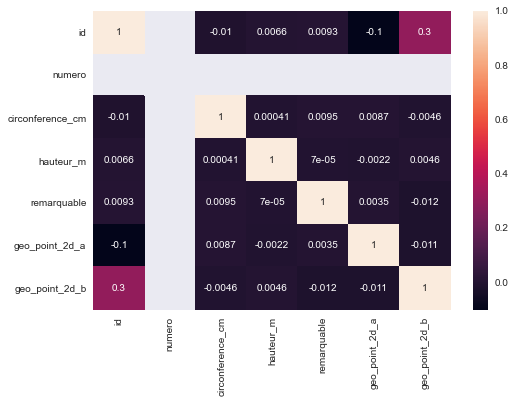

In [12]:
sns.heatmap(df.corr(), annot=True)
plt.show()

En se fiant à l'écart type, 2 colonnes sortent du lot : "circonference_cm" et "hauteur_m".
Leurs valeurs max sont en effet aberrant 250 255 centimètres pour la circonférence et 881 818 mètres pour la hauteur. Ces chiffres dépassent de manière évidente la réalité.

En ce qui concerne les valeurs égales à 0. Nous pouvons nous demander s'il faut le considérer comme une valeur nulle ou un arbre dont la valeur est inférieure à 1. En effet, le type de la colonne empêche d'afficher des nombres à virgule. Néanmoins, il est improbable d'avoir des arbres avec une circonférence de moins de 1cm. Ce qui remet en question les valeurs égales à 0.

Analysons plus en détail ces chiffres pour réfléchir comment résoudre ces valeurs.
Par exemple, comment pourrions-nous déterminer à partir de combien de mètres une valeur devient incorrecte ?
Sachant que ces valeurs ont forcément une corrélation avec l’espèce et l'âge de l'arbre, comment filtrer les valeurs convenablement ?

Procédons par étape. Nous pouvons d'abord visualiser ces 2 colonnes dans leur ensemble. Puis démontrer la corrélation évidente des dimensions d'un arbre par rapport à son âge et son espèce. Pour ensuite affiner la détection d'anomalie pour chaque type d'arbres selon leur âge.

### Analyse de la hauteur et de la circonférence

#### Nombre de valeurs égales à 0

In [13]:
nb0 = df[["circonference_cm", "hauteur_m"]]
nb0[nb0 == 0].count()

circonference_cm    25867
hauteur_m           39219
dtype: int64

Soit 12,9% des valeurs de circonference_cm sont des 0 et 19.6% pour hauteur_m. Compte tenu de leur nombre et du doute, il serait préférable de les supprimer à l'étape du nettoyage le temps de trouver une meilleure solution.

#### Identification des valeurs aberrantes avec l'écart interquartile (EI)

L'écart interquartile (EI) est une mesure de dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule EI = Q3 - Q1. Les lignes de code ci-dessous calculent et affichent l'écart interquartile pour la circonférence et la hauteur.

In [14]:
Q1 = df[["circonference_cm", "hauteur_m"]].quantile(0.25)
Q3 = df[["circonference_cm", "hauteur_m"]].quantile(0.75)
EI = Q3 - Q1
EI

circonference_cm    85.0
hauteur_m            7.0
dtype: float64

La sortie ci-dessus affiche les scores d'EI, qui peuvent être utilisés pour détecter les valeurs aberrantes.

Comme nous avons maintenant les scores d'EI, il est temps de s'intéresser aux valeurs aberrantes. Le code ci-dessous donnera une sortie avec des valeurs vraies et fausses.
Le point de données où nous avons False signifie que ces valeurs sont valides alors que True indique la présence d'une valeur aberrante.

In [15]:
df_outliers = (df[["hauteur_m", "circonference_cm"]] <
               (Q1 - 1.5 * EI)) | (df[["hauteur_m", "circonference_cm"]] >
                                   (Q3 + 1.5 * EI))
df_outliers

,circonference_cm,hauteur_m
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
200132,False,False
200133,False,False
200134,False,False
200135,False,False


In [16]:
pd.DataFrame(df_outliers.mean().round(4) * 100,
             columns=["% d'aberration"]).sort_values(by="% d'aberration",
                                                     ascending=False)

,% d'aberration
hauteur_m,1.95
circonference_cm,1.70


#### Identification des valeurs aberrantes avec asymétrie

Plusieurs algorithmes de Machine Learning partent du principe que les données suivent une distribution normale (ou gaussienne). Ceci est facile à vérifier avec la valeur d'asymétrie (skewness), qui explique dans quelle mesure les données sont distribuées normalement. Idéalement, la valeur d'asymétrie devrait être comprise entre -1 et +1, et tout écart important par rapport à cette plage indique la présence de valeurs extrêmes.

La première ligne de code ci-dessous affiche la valeur d'asymétrie pour la variable "circonference_cm" et "hauteur_m".

In [17]:
df[["circonference_cm", "hauteur_m"]].skew()

circonference_cm    298.156614
hauteur_m           447.294132
dtype: float64

La valeur d'asymétrie de 298,2 pour "circonference_cm" et 447,3 pour "hauteur_m" montre une distribution décalée à gauche de la médiane, et donc une queue de distribution étalée vers la droite. Ces valeurs indiquent la présence de valeurs extrêmes élevées. La valeur maximale 250 255 centimètres pour la circonférence et 881 818 mètres pour la hauteur en sont la preuve.

#### Identifier les valeurs aberrantes avec la visualisation

Dans la section précédente, nous avons utilisé des méthodes quantitatives pour l'identification des aberrations. La visualisation va nous permettre d'étoffer cette analyse. 

##### Analyse de la circonférence

Text(0.5, 1.0, 'Distribution de la circonférence (cm)')

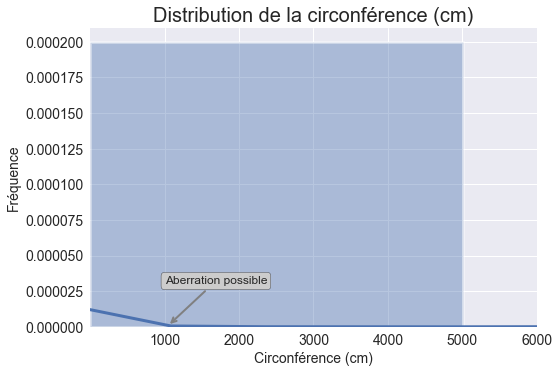

In [18]:
# histogramme et fonction d'estimation de la densité du noyau de la variable "circonference_cm"
ax = sns.distplot(df["circonference_cm"],
                  hist=True,
                  hist_kws={
                      "edgecolor": 'w',
                      "linewidth": 3
},
    kde_kws={"linewidth": 3})
ax.set(xlim=(1, 6000))

# notation indiquant une éventuelle valeur aberrante
ax.annotate('Aberration possible',
            xy=(1050, 0.000001),
            xytext=(1000, 0.00003),
            fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# étiquettes et titres
plt.xlabel('Circonférence (cm)', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Distribution de la circonférence (cm)', fontsize=20)

D'après le graphique, il y a une aberration possible à partir de 1000cm de circonférence.

Observons sa distribution dans un diagramme en boite.

Text(0.5, 1.0, 'Distribution de la circonférence (cm)')

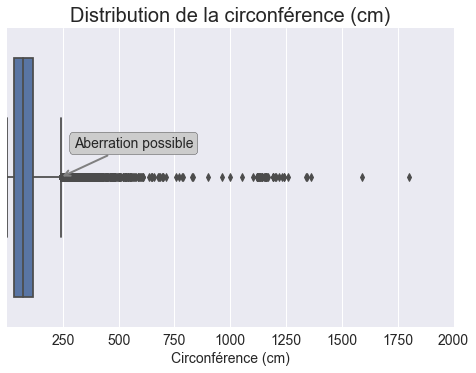

In [19]:
# diagramme en boite de la variable "circonference_cm".
ax = sns.boxplot(x=df["circonference_cm"])
ax.set(xlim=(1, 2000))

# notation indiquant une éventuelle valeur aberrante
ax.annotate('Aberration possible',
            xy=(240, 0),
            xytext=(300, -0.1),
            fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))

# xtick, étiquettes et titres
plt.xticks(fontsize=14)
plt.xlabel('Circonférence (cm)', fontsize=14)
plt.title('Distribution de la circonférence (cm)', fontsize=20)

Dans le résultat ci-dessus, les losanges indiquent les valeurs aberrantes, et elles sont nombreuses. Il est fortement probable que beaucoup de ces valeurs ne soient pas réellement aberrantes. Ici, l'anomalie commence à partir de 240 centimètres de circonférence, bien inférieurs des 1000 centimètres de la visualisation précédente.

Quand est-il de la hauteur ? :

##### Analyse de la hauteur

Text(0.5, 1.0, 'Distribution de la hauteur (m)')

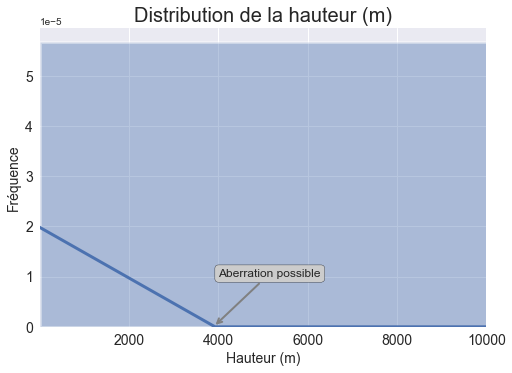

In [20]:
# histogramme et fonction d'estimation de la densité de la variable "hauteur_m"
ax = sns.distplot(df["hauteur_m"],
                  hist=True,
                  hist_kws={
                      "edgecolor": 'w',
                      "linewidth": 3
},
    kde_kws={"linewidth": 3})
ax.set(xlim=(1, 10000))

# notation indiquant une éventuelle valeur aberrante
ax.annotate('Aberration possible',
            xy=(3900, 0.0000001),
            xytext=(4000, 0.00001),
            fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# étiquettes et titres
plt.xlabel('Hauteur (m)', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Distribution de la hauteur (m)', fontsize=20)

La possibilité d'une aberration débute à partir de 4000 mètres de hauteur. Ce chiffre n'est pas réaliste.

Observons avec un diagramme en boite :

Text(0.5, 1.0, 'Distribution de la hauteur (m)')

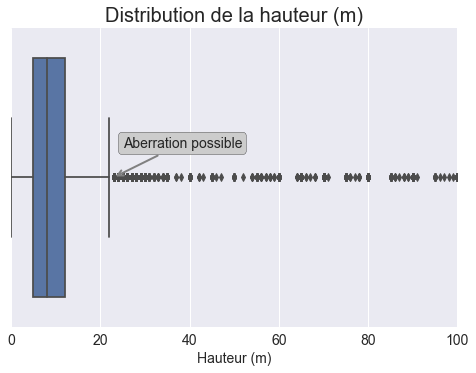

In [21]:
# diagramme en boite de la variable "hauteur_m".
ax = sns.boxplot(x=df["hauteur_m"])
ax.set(xlim=(0, 100))

# notation indiquant une éventuelle valeur aberrante
ax.annotate('Aberration possible',
            xy=(23, 0),
            xytext=(25, -0.1),
            fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))

# xtick, étiquettes et titres
plt.xticks(fontsize=14)
plt.xlabel('Hauteur (m)', fontsize=14)
plt.title('Distribution de la hauteur (m)', fontsize=20)

Ici, l'anomalie débute à partir de 22 mètres de hauteur, un résultat bien plus réaliste.

##### Nuage de points
Les histogrammes et les diagrammes en boite identifient les valeurs qui sont très éloignées des valeurs moyennes pour chaque caractéristique (valeurs aberrantes univariées). Cependant, ils ne permettent pas d'identifier un comportement anormal entre deux ou plusieurs variables (valeurs aberrantes multivariées). C'est là que les nuages de points sont utiles.

Text(0.5, 1.0, 'Relation entre hauteur et circonférence')

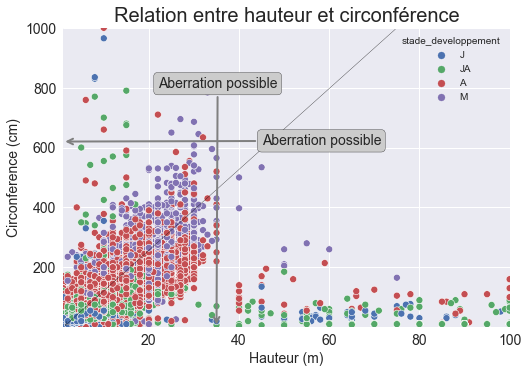

In [22]:
# nuage de points
ax = sns.scatterplot(x='hauteur_m',
                     y='circonference_cm',
                     data=df,
                     hue="stade_developpement",
                     hue_order=['J', 'JA', 'A', 'M'])
ax.set(xlim=(1, 100), ylim=(1, 1000))

# notation indiquant une éventuelle valeur aberrante
ax.annotate("",
            xy=(1.1, 1.1),
            xytext=(75, 1000),
            arrowprops=dict(arrowstyle="->"))
ax.annotate('Aberration possible',
            xy=(35, 1),
            xytext=(22, 800),
            fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))
ax.annotate('Aberration possible',
            xy=(1, 620),
            xytext=(45, 609),
            fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2),
            bbox=dict(boxstyle="round", fc="0.8"))

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# étiquettes et titres
plt.xlabel('Hauteur (m)', fontsize=14)
plt.ylabel('Circonference (cm)', fontsize=14)
plt.title('Relation entre hauteur et circonférence', fontsize=20)

Comme nous pouvons l'observer, la relation entre la hauteur et la circonférence est linéaire. De plus, nous identifions des valeurs aberrantes, en dehors de la zone indiquée dans le graphique et éloignée de l'axe central. Nous n'avions pas pu les détecter auparavant, car ses valeurs se situent dans les limites déterminées par la règle de proximité EI. Cependant, nous devons considérer ces points de données comme des valeurs aberrantes, car ils ne correspondent pas au modèle.

Aussi nous pouvons remarquer un dégradé linéaire de couleur logique selon le stade de développement des arbres :
1. J = Jeune (bleu)
2. JA = Jeune Adulte (vert)
3. A = Adulte (rouge)
4. M = Mature (violet)

Visuellement, les anomalies se situent delà de 600 centimètres de circonférence et 37 mètres de hauteur.
Il est possible de peaufiner l'analyse en affinant les critères par exemple en observant les dimensions des arbres par espèces groupées par stade de développement. L'utilisation des KNN (Méthode des k plus proches voisins) serait adaptée.

L'analyse des aberrations aurait pu continuer sur d'autres colonnes comme la localisation par exemple. Cependant pour ne pas nous perdre dans de longues analyses nous nous limitons à ceci et passons dorénavant au nettoyage.

## Nettoyage

Précédemment, nous avons vu la présence de données vide, d'erreur de type et d'anomalie de valeurs dans le jeu de données.

Nous allons donc adopter une stratégie de nettoyage pour les erreurs détectées les plus importantes. Ensuite, nous pourrons procéder à quelques analyses.

### Données manquantes et valeur unique

#### Suppression des variables "numéro", «variete" et "type_emplacement"

In [23]:
df.drop(['numero', 'variete', 'type_emplacement'], inplace=True, axis=1)

### Type de données

#### Conversion de "remarquable" en type booléen

In [24]:
df["remarquable"] = df["remarquable"].astype(bool)

### Doublons

Comme 2 arbres ne peuvent être au même endroit, le dernier doublon est probablement un arbre replanté. Donc nous supprimons le doublon le plus ancien et gardons le nouveau.

In [25]:
df = df.drop_duplicates(subset=['geo_point_2d_a', 'geo_point_2d_b'],
                        keep='last')

### Aberration

Précédemment, nous avons vu comment détecter les valeurs aberrantes à l'aide de l'écart interquartile (EI), mais maintenant nous voulons supprimer ou filtrer les valeurs aberrantes et obtenir des données propres. Ceci peut être fait en une seule ligne de code puisque nous avons déjà calculé l'EI.

In [26]:
df_out = df[~((df[["hauteur_m", "circonference_cm"]] <
               (Q1 - 1.5 * EI)) | (df[["hauteur_m", "circonference_cm"]] >
                                   (Q3 + 1.5 * EI))).any(axis=1)]

In [27]:
df_out.describe()

,id,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
count,1.939860e+05,193986.000000,193986.000000,193986.000000,193986.000000
mean,3.858330e+05,74.802754,7.925149,48.854705,2.347983
std,5.433208e+05,55.372056,5.704456,0.030190,0.051343
min,9.987400e+04,0.000000,0.000000,48.742290,2.210241
25%,1.562592e+05,30.000000,4.000000,48.835183,2.307208
50%,2.211515e+05,70.000000,8.000000,48.854264,2.350724
75%,2.739698e+05,110.000000,12.000000,48.876583,2.387042
max,2.024745e+06,242.000000,22.000000,48.911485,2.469759


Les valeurs max sont dorénavant plus proches de la réalité avec 22 mètres pour la hauteur au lieu de 881 818 mètres et 242 centimètres au lieu de 250 255 centimètres pour la circonférence.

Maintenant, nous pouvons analyser quelques données permettant de contribuer à l'optimisation des tournées pour l'entretien des arbres

## Analyse

Réfléchissons à des combinaisons de visualisation permettant d'optimiser les tournées d'entretien des arbres.

Par exemple, l'entretient des arbres dépend de l’âge, de l'espèce, des dimensions, du lieu et bien plus.

### Caractéristiques des arbres

Text(0, 0.5, 'Total')

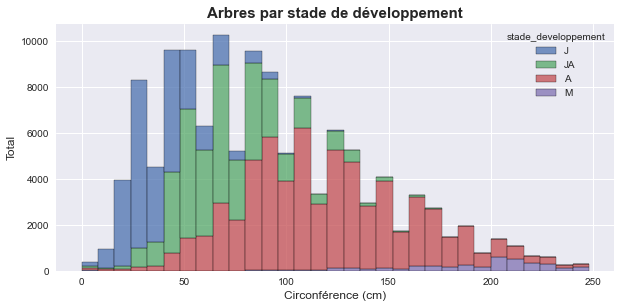

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
g = sns.histplot(data=df_out,
                 x="circonference_cm",
                 hue="stade_developpement",
                 hue_order=['J', 'JA', 'A', 'M'],
                 multiple="stack",
                 binwidth=8)
plt.title('Arbres par stade de développement', fontsize=15, fontweight='bold')
plt.xlabel('Circonférence (cm)', fontsize=12)
plt.ylabel('Total', fontsize=12)

Logiquement, plus un arbre est jeune moins sa circonférence est élevée.
Ce graphique nous donne une indication au sujet du financement de matériel d'entretien.
On remarque que les arbres les plus jeunes sont les plus nombreux, J, puis JA, ensuite A et M.
Donc pour l'inventaire du matériel, le nombre de stocks doit être plus élevé pour les arbres jeunes que mature.

### Analyse géographique

Pour optimiser les tournées, nous pouvons analyser la prédominance de stade de développement d'arbre par zone afin d'améliorer le transport de matériel.

<AxesSubplot:xlabel='geo_point_2d_a', ylabel='geo_point_2d_b'>

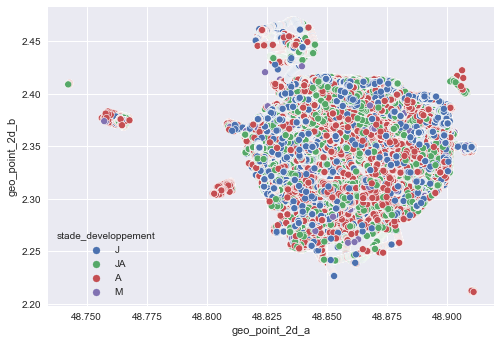

In [29]:
sns.scatterplot(data=df_out,
                x="geo_point_2d_a",
                y="geo_point_2d_b",
                hue='stade_developpement',
                hue_order=['J', 'JA', 'A', 'M'])

Assez difficile à percevoir les zones prédominantes. Une carte de chaleur serait plus adaptée.

<AxesSubplot:xlabel='stade_developpement', ylabel='arrondissement'>

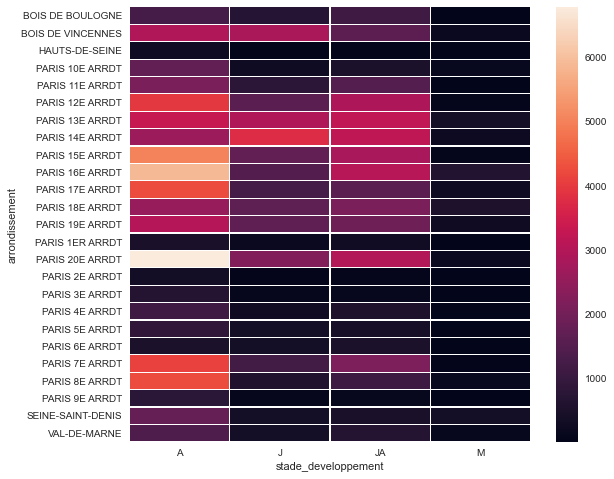

In [30]:
plt.figure(figsize=(9, 8))
sns.heatmap(df_out[["arrondissement", "stade_developpement"
                    ]].pivot_table(index="arrondissement",
                                   columns="stade_developpement",
                                   aggfunc=len),
            linewidths=.1)

Par exemple de cette manière nous pouvons en conclure que lors du trajet au 20E arrondissement il faudra principalement prévoir du matériel pour arbre adulte comme des nacelles ou tronçonneuses.

### Cartographie

Afin de rendre la visualisation interactive, nous pouvons exposer les données sur une carte.
Pour cela, nous allons fusionner nos informations avec un plan affichant les communes de Paris afin de voir le total d’arbres que contient chacune d’elles.

In [31]:
#  Conversion en de la dataframe en géodataframe
gdf_listings = gpd.GeoDataFrame(df_out,
                                geometry=gpd.points_from_xy(
                                    df_out.geo_point_2d_b,
                                    df_out.geo_point_2d_a))
# Chargement des arrondissements
geojson_file = "data/communes-75-paris.geojson"
neighborhoods = gpd.read_file(geojson_file)

# Fusion des arrondissements avec la dataframe
sjoined_listings = gpd.sjoin(gdf_listings, neighborhoods, op="within")
sjoined_listings.head()

,id,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b,geometry,index_right,code,nom
0,99874,Jardin,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,20,5,NaN,False,48.857620,2.320962,POINT (2.32096 48.85762),12,75107,Paris 7e Arrondissement
1,99875,Jardin,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,65,8,A,True,48.857656,2.321031,POINT (2.32103 48.85766),12,75107,Paris 7e Arrondissement
2,99876,Jardin,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,90,10,A,True,48.857705,2.321061,POINT (2.32106 48.85771),12,75107,Paris 7e Arrondissement
3,99877,Jardin,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,60,8,A,True,48.857722,2.321006,POINT (2.32101 48.85772),12,75107,Paris 7e Arrondissement
433,100486,Jardin,PARIS 7E ARRDT,NaN,JARDIN DU CHAMP DE MARS,A0120353,Tilleul,Tilia,n. sp.,133,13,A,False,48.854256,2.301751,POINT (2.30175 48.85426),12,75107,Paris 7e Arrondissement


In [32]:
# Jointure du nombre d’arbres par arrondissement

grouped = sjoined_listings.groupby("nom").size()
mapdf = grouped.to_frame().reset_index()
mapdf.columns = ["nom", "Nombre"]
mapdf

,nom,Nombre
0,Paris 10e Arrondissement,3131
1,Paris 11e Arrondissement,5293
2,Paris 12e Arrondissement,22934
3,Paris 13e Arrondissement,16021
4,Paris 14e Arrondissement,11042
5,Paris 15e Arrondissement,16442
6,Paris 16e Arrondissement,19635
7,Paris 17e Arrondissement,10177
8,Paris 18e Arrondissement,9805
9,Paris 19e Arrondissement,12932


In [33]:
#Fusion avec la carte des arrondissements

merged_areas = neighborhoods.merge(mapdf, on="nom", how="outer")
merged_areas.shape, neighborhoods.shape

((20, 4), (20, 3))

In [34]:
## Mis en place de la carte

# Titre et dégradé de couleurs
colormap = branca.colormap.LinearColormap(
    vmin=merged_areas["Nombre"].quantile(0.0),
    vmax=merged_areas["Nombre"].quantile(1),
    colors=["#F1F8E9", "#9CCC65", "#81C784", "#43A047", "#1B5E20"],
    caption="Arbres par arrondissement",
)

# Zoom sur Paris
m = folium.Map(location=[48.8632915, 2.3394145], zoom_start=12)

# Popup
popup = GeoJsonPopup(
    fields=["nom", "Nombre"],
    aliases=["Lieu", "Nombre d'arbres"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)

# Tooltip
tooltip = GeoJsonTooltip(
    fields=["nom", "Nombre"],
    aliases=["Lieu : ", "Nombre d'arbres : "],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# Carte
g = folium.GeoJson(
    merged_areas,
    style_function=lambda x: {
        "fillColor":
        colormap(x["properties"]["Nombre"])
        if x["properties"]["Nombre"] is not None else "transparent",
        "color":
        "black",
        "fillOpacity":
        0.7,
    },
    tooltip=tooltip,
    popup=popup,
).add_to(m)

colormap.add_to(m)

m

Cette cartographie peut permettre de prendre des décisions sur les zones qui demandent une plus grande équipe d’entretien.

## Synthèse

Durant ces différentes étapes, nous avons vu comment un jeu de données peut divulguer énormément d’informations et à quel point son analyse peut rapidement devenir chronophage si l’on approfondit de plus en plus la recherche.

Actuellement, pour la démonstration, nous avons simplement exploré de manière superficielle et proposé quelques solutions d’optimisations.
Nous aurions pu aller beaucoup en analysant les différentes espèces au cas par cas, étudier les lieux, etc.
À supposer que l’on ait épuisé toutes les possibilités de recherche sur ce jeu de données, l’intelligence artificielle permet d’ouvrir une porte avec encore plus de possibilités. Par exemple, il pourrait nous être possible de mettre en place système de carnet de santé d’arbres accompagné d’un score sur 10. L’IA peut analyser les dimensions habituelles d’une espèce selon son âge et par rapport à ça lui donner un score. À l’image d’un carnet de santé où le docteur analyse la courbe de poids du bébé par rapport à son âge. Ce carnet de santé pourrait aussi permettre d’anticiper à quel moment un arbre a besoin d’être maintenant. Ce qui peut produire par la suite un outil de planning automatisé pour la gestion des entretiens des arbres. Une excellente manière de répondre à la demande de Paris.